<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/vae_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: VAE, GAN, Transformer

## Download Data

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz

--2024-10-14 20:49:09--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.158, 3.5.134.83, 3.5.136.48, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.136.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  10.5MB/s    in 2.4s    

2024-10-14 20:49:12 (10.5 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-14 20:49:12--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.136.158, 3.5.134.83, 3.

## Library Imports

In [112]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [94]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: Tesla T4
GPU Count: 1
GPU Memory Allocated: 114021888
GPU Memory Cached: 140509184


## Load Data

### Define FashionMNIST

In [113]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = (np.copy(imgs) / 255).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = label.to(self.device)
            return img, label
        else:
            return img

    def stratified_indices(self, num_labels, removed_indicies=[]):
        """
        Create a stratified subset of the dataset using num_labels data points
        """
        # Get remaining indices after removing removed_indicies
        remaining_indices = np.setdiff1d(np.arange(len(self)), removed_indicies)

        indices = []
        for cls in range(10):
            cls_indices = remaining_indices[self.labels[remaining_indices] == cls]
            num_to_select = min(len(cls_indices), num_labels // 10)
            selected_indices = np.random.choice(cls_indices, num_to_select, replace=False)
            indices.extend(selected_indices.tolist())
        return indices

    def create_subsets(self, num_labels):
        """Create labeled and unlabeled subsets with no overlapping indices."""
        assert num_labels <= len(self), "Number of labels must be less than or equal to the dataset size"

        labeled_indices = self.stratified_indices(num_labels)

        all_indices = set(range(len(self)))
        remaining_indices = list(all_indices - set(labeled_indices))

        remaining_dataset = self.labels[remaining_indices]
        unlabeled_indices = self.stratified_indices(num_labels, labeled_indices)

        labeled_subset = torch.utils.data.Subset(self, labeled_indices)
        unlabeled_subset = torch.utils.data.Subset(self, unlabeled_indices)

        return labeled_subset, unlabeled_subset

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

### Unlabeled/Labeled Split & Data Loaders

In [114]:
gen = torch.Generator().manual_seed(123)

def create_datasets(num_labels, batch_size, device):
    PATH = '/content'

    train = FasionMNISTDataset(PATH, 'train', device=device)
    labeled, unlabeld = train.create_subsets(num_labels)
    test = FasionMNISTDataset(PATH, 'test', device=device)

    batch = batch_size
    labeledloader = DataLoader(labeled, batch, shuffle=True, generator=gen)
    unlabeledloader = DataLoader(unlabeld, batch, shuffle=True, generator=gen)
    testloader = DataLoader(test, batch, shuffle=True, generator=gen)

    data = {
        'labeled': labeled,
        'unlabeled': unlabeld,
        'test': test
    }

    dataloaders = {
        'labeled': labeledloader,
        'unlabeled': unlabeledloader,
        'test': testloader
    }
    return data, dataloaders

data, dataloaders = create_datasets(100, 8, device)


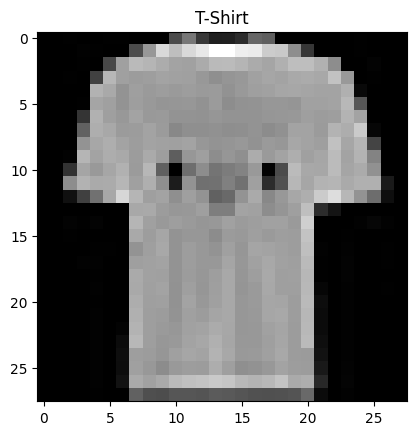

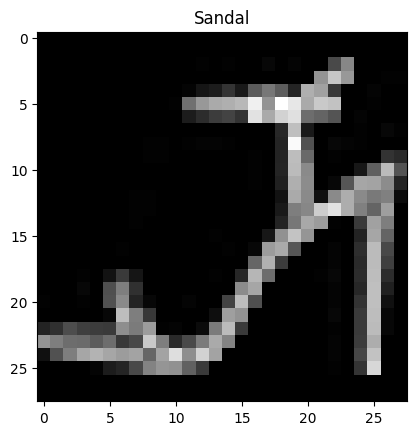

In [115]:
show_img(data['labeled'], 0)
show_img(data['labeled'],50)

In [116]:
class Gaussian(nn.Module):
    def __init__(self, inputs: int, outputs:int):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs

        #create mu & log_var
        self.mu = nn.Linear(inputs, outputs)
        self.log_var = nn.Linear(inputs, outputs)

    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        log_var = F.softplus(log_var)


        return self.trick(mu, log_var), mu, log_var

    def trick(self, mu, log_var):
        """
        Return a sample from the gausian returned by mu & log_var
        """
        std_dev = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std_dev)
        return epsilon.mul(std_dev).add_(mu)


class Encoder(nn.Module):
    def __init__(self, inputs: int, hidden: list[int], latent: int):
        super().__init__()
        self.inputs = inputs
        self.hidden = hidden
        self.latent = latent

        self.fc0 = nn.Linear(inputs, hidden[0])

        for idx in range(1, len(hidden)):
            self.__setattr__(f'fc{idx}', nn.Linear(hidden[idx-1], hidden[idx]))
        self.gaussian = Gaussian(hidden[-1], latent)

        self.softplus = nn.Softplus()

    def forward(self, x):
        for idx in range(len(self.hidden)):
            x = self.softplus(self.__getattr__(f'fc{idx}')(x))
        return self.gaussian(x)

class Decoder(nn.Module):
    def __init__(self, latent: int, hidden: list[int], outputs: int):
        super().__init__()
        self.latent = latent
        self.hidden = hidden
        self.outputs = outputs

        self.fc0 = nn.Linear(latent, hidden[0])

        for idx in range(1, len(hidden)):
            self.__setattr__(f'fc{idx}', nn.Linear(hidden[idx-1], hidden[idx]))

        self.fc_out = nn.Linear(hidden[-1], outputs)

        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for idx in range(len(self.hidden)):
            x = self.softplus(self.__getattr__(f'fc{idx}')(x))
        return self.sigmoid(self.fc_out(x))

class VAE(nn.Module):
    def __init__(self, inputs: int, hidden: list[int], latent: int):
        super().__init__()

        self.inputs = inputs
        self.hidden = hidden
        self.latent = latent

        self.encoder = Encoder(inputs, hidden, latent)
        self.decoder = Decoder(latent, hidden[::-1], inputs)

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        return self.decoder(z), z, mu, log_var


In [117]:
from sklearn.utils.validation import check_is_fitted

def vae_loss(x_hat, x, z, mu, log_var, y_hat = None, y = None):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    if y_hat is not None:
        classification_loss = F.binary_cross_entropy(y_hat, y)
        return classification_loss + reconstruction_loss + kl_divergence
    return reconstruction_loss + kl_divergence

def get_tensor_info(tensor):
    print(f"Shape: {tensor.shape}")
    print(f"Data Type: {tensor.dtype}")
    print(f"Device: {tensor.device}")
    print(f"Min: {tensor.min()}")
    print(f"Max: {tensor.max()}")
    print(f"Mean: {tensor.mean()}")
    print(f"Standard Deviation: {tensor.std()}")

def train_one_epoch(model, classifier, dataloaders, loss_fn, optimizer, epoch, device, verbosity):
    model.train()
    running_loss = 0.0

    for i, ((x_labeled, y_labeled), (x_unlabeled, _)) in enumerate(zip(dataloaders['labeled'], dataloaders['unlabeled'])):


        optimizer.zero_grad()

        x_hat_lbl, z_lbl, mu_lbl, log_var_lbl = model(x_labeled.view(-1, 28 * 28))
        x_hat_unlbl, z_unlbl, mu_unlbl, log_var_unlbl = model(x_unlabeled.view(-1, 28 * 28))

        try:
            check_is_fitted(classifier)
            latent_vectors = z_lbl.detach().cpu().numpy()
            predicted_labels = torch.tensor(svm.predict(latent_vectors),dtype=torch.float32).to(device)
            loss = loss_fn(x_hat_lbl, x_labeled.view(-1, 28 * 28), z_lbl, mu_lbl, log_var_lbl, predicted_labels, y_labeled)
            loss += loss_fn(x_hat_unlbl, x_unlabeled.view(-1, 28 * 28), z_unlbl, mu_unlbl, log_var_unlbl)
        except:
            loss = loss_fn(x_hat_lbl, x_labeled.view(-1, 28 * 28), z_lbl, mu_lbl, log_var_lbl)
            loss += loss_fn(x_hat_unlbl, x_unlabeled.view(-1, 28 * 28), z_unlbl, mu_unlbl, log_var_unlbl)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % verbosity == 0:
            print(f'Batch #{i + 1} Loss: {running_loss / verbosity}')
            running_loss = 0.0


def get_latent(model, device, data):
    model.eval()

    latent = []
    labels = []

    with torch.no_grad():
        for x, y in data:
            x, y = x.to(device), y.to(device)

            z, _, _ = model.encoder(x.view(-1, 28 * 28))
            latent.append(z)
            labels.append(y)

    return torch.cat(latent).cpu().numpy(), torch.cat(labels).cpu().numpy()

def train_vae(model, dataloaders, loss_fn, optimizer, device, epochs: int, verbosity: int):
    """Train network for given number of epochs using optimizer and loss_fn"""

    svm = SVC(kernel='rbf', random_state=123)

    print('----------- VAE Train Start! ------------')
    for epoch in range(epochs):
        print(f'----------- Epoch #{epoch + 1} ------------')
        train_one_epoch(model, svm, dataloaders, loss_fn, optimizer, device, epoch, verbosity)
        latent, labels = get_latent(model, device, dataloaders['labeled'])
        svm.fit(latent, labels)
        print('------------------------------------\n')
    print('----------- VAE Train Complete! ------------')

    return get_latent(model, device, dataloaders['labeled'])

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_svm_head(latent, labels, kernel, C=1):
    svm = SVC(kernel=kernel, random_state=123, C=C)
    svm.fit(latent, labels)
    return svm

def eval_metrics(model, train_labels, train_preds, test_labels, test_preds):
    print(f"------ Classification Metrics ------")
    print('Metric\t\tTrain\t\tTest')
    print('Accuracy:\t',round(accuracy_score(train_labels,train_preds),5),'\t',round(accuracy_score(test_labels, test_preds),5))
    print('Recall:\t\t',round(recall_score(train_labels,train_preds, average='macro'),5),'\t',round(recall_score(test_labels, test_preds, average='macro'),5))
    print('Precision:\t',round(precision_score(train_labels,train_preds, average='macro'),5),'\t',round(precision_score(test_labels, test_preds, average='macro'),5))
    print('F1 Score:\t',round(f1_score(train_labels,train_preds, average='macro'),5),'\t',round(f1_score(test_labels, test_preds, average='macro'),5))
    print('------------------------------------\n')

In [118]:
input = 28 * 28
hidden = [600, 600]
latent = 50
num_labels = [100, 600, 1000, 3000]
epochs = 50
verbosity = 10
batch = 32

torch.cuda.empty_cache()
vae = VAE(input, hidden, latent)
adam = optim.Adam(vae.parameters(), lr=1e-3)
vae = vae.to(device)

In [119]:
data, dataloaders = create_datasets(3000, batch, device)
train_latent_vectors, train_labels = train_vae(vae, dataloaders, vae_loss, adam, device, epochs, verbosity)
svm = train_svm_head(train_latent_vectors, train_labels,'rbf')
train_preds = svm.predict(train_latent_vectors)
test_latent_vectors, test_labels = get_latent(vae, device, dataloaders['test'])
test_preds = svm.predict(test_latent_vectors)
eval_metrics(svm, train_labels, train_preds, test_labels, test_preds)

----------- VAE Train Start! ------------
----------- Epoch #1 ------------
Batch #10 Loss: 27571.9201171875
Batch #20 Loss: 24997.9267578125
Batch #30 Loss: 24748.7087890625
Batch #40 Loss: 24597.774609375
Batch #50 Loss: 23213.2599609375
Batch #60 Loss: 22797.251171875
Batch #70 Loss: 22182.0455078125
Batch #80 Loss: 21302.3361328125
Batch #90 Loss: 20923.8384765625
------------------------------------

----------- Epoch #2 ------------
Batch #10 Loss: 20138.9599609375
Batch #20 Loss: 19675.0984375
Batch #30 Loss: 19749.4732421875
Batch #40 Loss: 19760.7388671875
Batch #50 Loss: 19437.598046875
Batch #60 Loss: 20067.171875
Batch #70 Loss: 19669.8958984375
Batch #80 Loss: 19930.27265625
Batch #90 Loss: 19412.200390625
------------------------------------

----------- Epoch #3 ------------
Batch #10 Loss: 19738.0611328125
Batch #20 Loss: 19475.946484375
Batch #30 Loss: 19422.105078125
Batch #40 Loss: 19336.4234375
Batch #50 Loss: 19592.2236328125
Batch #60 Loss: 19005.6197265625
Batch 

In [122]:
svm = train_svm_head(train_latent_vectors, train_labels,'rbf',C=0.5)
train_preds = svm.predict(train_latent_vectors)
test_latent_vectors, test_labels = get_latent(vae, device, dataloaders['test'])
test_preds = svm.predict(test_latent_vectors)
eval_metrics(svm, train_labels, train_preds, test_labels, test_preds)

------ Classification Metrics ------
Metric		Train		Test
Accuracy:	 0.81733 	 0.6911
Recall:		 0.81733 	 0.6911
Precision:	 0.81695 	 0.68908
F1 Score:	 0.81652 	 0.68912
------------------------------------



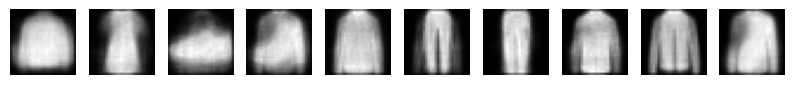

In [123]:
import matplotlib.pyplot as plt

def generate_images(model, num_images, latent_dim, device):
    # Set the model to evaluation mode
    model.eval()

    # Sample from a standard normal distribution in the latent space
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)  # latent_dim is the size of the latent vector
        generated_images = model.decoder(z)  # Pass through decoder to get reconstructed images
        generated_images = generated_images.view(num_images, 28, 28).cpu()  # Reshape and move to CPU

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axes[i].imshow(generated_images[i], cmap='gray')
        axes[i].axis('off')
    plt.show()

# Example usage:
num_images = 10  # Specify how many images you want to generate
latent_dim = 50  # Latent dimension used during training
generate_images(vae, num_images, latent_dim, device)